# Business Understanding

# Data Understanding

# Data Preparation

In [1540]:
import pandas as pd

vaccine = pd.read_csv('data/training_set_features.csv')
vaccine.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [1541]:
vaccine_label = pd.read_csv('data/training_set_labels.csv')
vaccine_label.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [1542]:
vaccine = vaccine.merge(vaccine_label, on='respondent_id')

In [1543]:
vaccine.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [1544]:
vaccine.drop(columns='seasonal_vaccine',inplace=True)

In [1545]:
vaccine.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0


In [1546]:
vaccine.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine'],
      dtype='object')

In [1547]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [1548]:
vaccine.drop(columns=['respondent_id', 'doctor_recc_seasonal','opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc',
                     'employment_industry','employment_occupation'], inplace=True)

In [1549]:
vaccine.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0


In [1550]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  chronic_med_condition        25736 non-null  float64
 11  child_under_6_months         25887 non-null  float64
 12  health_worker                25903 non-null  float64
 13  health_insurance

In [1551]:
vaccine.groupby(['h1n1_vaccine','health_insurance'])['health_insurance'].count()

h1n1_vaccine  health_insurance
0             0.0                 1480
              1.0                 8663
1             0.0                  256
              1.0                 4034
Name: health_insurance, dtype: int64

In [1552]:
vaccine['health_insurance'].isna().sum()

12274

In [1553]:
vaccine.drop(columns=['health_insurance'],inplace=True)

In [1554]:
vaccine.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0


In [1555]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  chronic_med_condition        25736 non-null  float64
 11  child_under_6_months         25887 non-null  float64
 12  health_worker                25903 non-null  float64
 13  opinion_h1n1_vac

In [1556]:
vaccine['doctor_recc_h1n1'] = vaccine['doctor_recc_h1n1'].fillna(0.0)

In [1557]:
vaccine['income_poverty'] = vaccine['income_poverty'].fillna('<= $75,000, Above Poverty')

In [1558]:
vaccine['rent_or_own'] = vaccine['rent_or_own'].fillna('Own')

In [1559]:
vaccine = vaccine.dropna(how='any',axis=0)

In [1560]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24025 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24025 non-null  float64
 1   h1n1_knowledge               24025 non-null  float64
 2   behavioral_antiviral_meds    24025 non-null  float64
 3   behavioral_avoidance         24025 non-null  float64
 4   behavioral_face_mask         24025 non-null  float64
 5   behavioral_wash_hands        24025 non-null  float64
 6   behavioral_large_gatherings  24025 non-null  float64
 7   behavioral_outside_home      24025 non-null  float64
 8   behavioral_touch_face        24025 non-null  float64
 9   doctor_recc_h1n1             24025 non-null  float64
 10  chronic_med_condition        24025 non-null  float64
 11  child_under_6_months         24025 non-null  float64
 12  health_worker                24025 non-null  float64
 13  opinion_h1n1_vacc_eff

In [1561]:
vaccine[vaccine['h1n1_vaccine']==1].groupby('age_group')[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine',
                                                                                              ascending=False)

,h1n1_vaccine
age_group,
65+ Years,1380
55 - 64 Years,1265
45 - 54 Years,938
18 - 34 Years,886
35 - 44 Years,691


In [1562]:
vaccine[vaccine['h1n1_vaccine']==1].groupby('income_poverty')[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine',
                                                                                              ascending=False)

,h1n1_vaccine
income_poverty,
"<= $75,000, Above Poverty",3003
"> $75,000",1675
Below Poverty,482


In [1563]:
vaccine[vaccine['h1n1_vaccine']==1].groupby('census_msa')[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine',
                                                                                              ascending=False)

,h1n1_vaccine
census_msa,
"MSA, Not Principle City",2240
"MSA, Principle City",1506
Non-MSA,1414


# Exploratory Data Analysis

# Model

In [1564]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24025 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24025 non-null  float64
 1   h1n1_knowledge               24025 non-null  float64
 2   behavioral_antiviral_meds    24025 non-null  float64
 3   behavioral_avoidance         24025 non-null  float64
 4   behavioral_face_mask         24025 non-null  float64
 5   behavioral_wash_hands        24025 non-null  float64
 6   behavioral_large_gatherings  24025 non-null  float64
 7   behavioral_outside_home      24025 non-null  float64
 8   behavioral_touch_face        24025 non-null  float64
 9   doctor_recc_h1n1             24025 non-null  float64
 10  chronic_med_condition        24025 non-null  float64
 11  child_under_6_months         24025 non-null  float64
 12  health_worker                24025 non-null  float64
 13  opinion_h1n1_vacc_eff

In [1565]:
#Class imbalance

vaccine['h1n1_vaccine'].value_counts(normalize=True)

h1n1_vaccine
0    0.785224
1    0.214776
Name: proportion, dtype: float64

In [1566]:

vaccine['household_adults'] = vaccine['household_adults'].apply(lambda x: 'other adults' if x >= 1 else 'no other adults')
vaccine['household_children'] = vaccine['household_children'].apply(lambda x: 'children' if x >= 1 else 'no children')
    

In [1567]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24025 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24025 non-null  float64
 1   h1n1_knowledge               24025 non-null  float64
 2   behavioral_antiviral_meds    24025 non-null  float64
 3   behavioral_avoidance         24025 non-null  float64
 4   behavioral_face_mask         24025 non-null  float64
 5   behavioral_wash_hands        24025 non-null  float64
 6   behavioral_large_gatherings  24025 non-null  float64
 7   behavioral_outside_home      24025 non-null  float64
 8   behavioral_touch_face        24025 non-null  float64
 9   doctor_recc_h1n1             24025 non-null  float64
 10  chronic_med_condition        24025 non-null  float64
 11  child_under_6_months         24025 non-null  float64
 12  health_worker                24025 non-null  float64
 13  opinion_h1n1_vacc_eff

In [1568]:
import pandas as pd
encoded_vaccine = pd.DataFrame()


In [1569]:
encoded_vaccine

""


In [1570]:
encoded_cols = []

for col in vaccine.columns:
    if vaccine[col].dtype == 'O':
        encoded_cols.append(col)
        
encoded_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

In [1571]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

for col in encoded_cols:
    
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    ohe.fit(vaccine[[col]])

    vaccine_ohe = pd.DataFrame(
        ohe.transform(vaccine[[col]]),
        index=vaccine_ohe.index,
        columns=np.hstack(ohe.categories_)
    )
    
    col_dict = {}
    for col in vaccine_ohe.columns:
        col_dict[col] = vaccine_ohe[col].sum()
    
    
        
    minimum = [k for k,v in col_dict.items() if v == min(col_dict.values())]
    
    
    vaccine_ohe.drop(columns=minimum, inplace = True)
    
    
    encoded_vaccine = pd.concat([encoded_vaccine,vaccine_ohe], axis=1)
    

In [1572]:
encoded_vaccine

,18 - 34 Years,45 - 54 Years,55 - 64 Years,65+ Years,12 Years,College Graduate,Some College,Black,Hispanic,White,...,kbazzjca,lrircsnp,lzgpxyit,mlyzmhmf,oxchjgsf,qufhixun,"MSA, Not Principle City","MSA, Principle City",other adults,no children
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26700,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
26701,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
26702,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
26703,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [1573]:
vaccine.drop(columns=encoded_cols,inplace = True)

In [1574]:
vaccine = pd.concat([vaccine, encoded_vaccine], axis=1)

In [1575]:
vaccine.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,kbazzjca,lrircsnp,lzgpxyit,mlyzmhmf,oxchjgsf,qufhixun,"MSA, Not Principle City","MSA, Principle City",other adults,no children
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [1576]:
# Import the relevant function
from sklearn.model_selection import train_test_split
# Define our X and y
X = vaccine.drop(columns = ['h1n1_vaccine'], axis=1)
y = vaccine['h1n1_vaccine']

In [1577]:
X_train_all, X_hold_out, y_train_all, y_hold_out = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [1578]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42, stratify=y_train_all)

In [1579]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,kbazzjca,lrircsnp,lzgpxyit,mlyzmhmf,oxchjgsf,qufhixun,"MSA, Not Principle City","MSA, Principle City",other adults,no children
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [1580]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: h1n1_vaccine, dtype: int64

In [1607]:
print("Train percent:", y_train.value_counts(normalize=True)[1])
print("Test percent: ", y_valid.value_counts(normalize=True)[1])
print("Test percent: ", y_hold_out.value_counts(normalize=True)[1])

Train percent: 0.21477712898190437
Test percent:  0.21479768786127168
Test percent:  0.21473158551810237


In [1628]:
# Import relevant class and function
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Instantiate a LogisticRegression with random_state=42
baseline_model = LogisticRegression()
baseline_model.fit(X_train,y_train)
# Use cross_val_score with scoring="recall" or "f1" to evaluate the model
# on X_train and y_train
baseline_recall_logreg = cross_val_score(baseline_model, X_train, y_train, scoring="recall")
baseline_f1_logreg = cross_val_score(baseline_model, X_train, y_train, scoring="f1")
baseline_loss_logreg = cross_val_score(baseline_model, X_train, y_train, scoring="neg_log_loss")

print(np.mean(baseline_recall_logreg))
print(np.mean(baseline_f1_logreg))
print(np.mean(baseline_loss_logreg))

/Users/jacklocke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jacklocke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

0.4314939434724091
0.529997860138989
-0.3849637153918405


/Users/jacklocke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1629]:
#baseline_recall_logreg = cross_val_score(baseline_model, X_valid, y_valid, scoring="recall")
#baseline_f1_logreg = cross_val_score(baseline_model, X_valid, y_valid, scoring="f1")
#baseline_loss_logreg = cross_val_score(baseline_model, X_valid, y_valid, scoring="neg_log_loss")

#print(np.mean(baseline_recall_logreg))
#print(np.mean(baseline_f1_logreg))
#print(np.mean(baseline_loss_logreg))

In [1630]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [1631]:
y_pred_new_threshold = (baseline_model.predict_proba(X_train)[:, 1] >= 0.15).astype(int) 

In [1632]:
print("Recall:  ", recall_score(y_train, y_pred_new_threshold))
print("f1:  ", f1_score(y_train, y_pred_new_threshold))

Recall:   0.8201884253028264
f1:   0.5523429710867397


In [1633]:
#y_hat_train = baseline_model.predict(X_train)

In [1634]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Print confusion matrix
cnf_matrix = confusion_matrix(y_train, y_pred_new_threshold)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[9311 4271]
 [ 668 3047]]


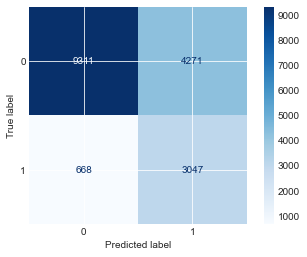

In [1635]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=model_log.classes_)
disp.plot(cmap=plt.cm.Blues)

In [1636]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Use cross_val_score with scoring="recall" or "f1" to evaluate the model
# on X_train and y_train
baseline_recall_dt = cross_val_score(dt, X_train, y_train, scoring="recall")
baseline_f1_dt = cross_val_score(dt, X_train, y_train, scoring="f1")
baseline_loss_dt = cross_val_score(dt, X_train, y_train, scoring="neg_log_loss")

print(np.mean(baseline_recall_dt))
print(np.mean(baseline_f1_dt))
print(np.mean(baseline_loss_dt))

0.4570659488559892
0.4407205662534608
-8.3447541825884


In [1639]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

baseline_recall_rfc = cross_val_score(rfc, X_train, y_train, scoring="recall")
baseline_f1_rfc = cross_val_score(rfc, X_train, y_train, scoring="f1")
baseline_loss_rfc = cross_val_score(rfc, X_train, y_train, scoring="neg_log_loss")

print(np.mean(baseline_recall_rfc))
print(np.mean(baseline_f1_rfc))
print(np.mean(baseline_loss_rfc))

0.39219380888290717
0.4944091824003145
-0.4058851988625216


# Conclusion

## Limitations

## Recommendations

## Next Steps